In [485]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from matplotlib import font_manager
from matplotlib.lines import Line2D

%matplotlib inline

In [498]:
label_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Ubuntu-R.ttf')
title_font = font_manager.FontProperties(fname='C:\\WINDOWS\\Fonts\\Mandalore-K77lD.otf')

# Process data

In [113]:
episodes = ["1", "2", "3", "4", "5", "6"]

# load files
df = []
for episode in episodes:
    df_episode = pd.read_csv("star_wars_%s_data.csv" %(episode), sep=";") 
    df_episode["episode"] = episode
    df_episode.columns = df_episode.columns.str.replace("adverbes", "adverbs")
    df.append(df_episode)

df = pd.concat(df)
df.head()

,id,from,to,text,text to check,where,number,nouns,determiners,conjuctions,adjectives,prepositions,pronouns,verbs,adverbs,undefined,time,episode
0,1.0,QUI-GON,CAPTAIN,Captain.,NaN,INT. REPUBLIC CRUISER - COCKPIT,1,0,0,0,0,0,0,0,0,0,9.0,1
1,2.0,CAPTAIN,QUI-GON,"Yes, sir?",NaN,INT. REPUBLIC CRUISER - COCKPIT,2,0,0,0,0,0,0,0,0,0,18.0,1
2,3.0,QUI-GON,CAPTAIN,Tell them we wish to board at once.,NaN,INT. REPUBLIC CRUISER - COCKPIT,8,0,0,0,0,0,0,0,0,0,72.0,1
3,4.0,CAPTAIN,QUI-GON,"Yes, sir.",NaN,INT. REPUBLIC CRUISER - COCKPIT,2,0,0,0,0,0,0,0,0,0,18.0,1
4,5.0,CAPTAIN,NUTE,With all due respect the ambassadors for the s...,NaN,INT. REPUBLIC CRUISER - COCKPIT,14,0,0,0,0,0,0,0,0,0,126.0,1


In [155]:
# fix data
df.loc[df["to"]=="QUI-GON :Your negotiations seem", "text"] = "Your negotiations seem"
df["to"] = df["to"].str.replace("QUI-GON :Your negotiations seem", "QUI-GON")

df.loc[df["to"]=="ANAKIN: The forward stabalizer.", "text"] = "The forward stabalizer"
df["to"] = df["to"].str.replace("ANAKIN: The forward stabalizer.", "ANAKIN")

df.loc[df["to"]=="QUI-GON :They wouldn't dare.", "text"] = "They wouldn't dare."
df["to"] = df["to"].str.replace("QUI-GON :They wouldn't dare.", "QUI-GON")

# strip white space
columns = ["to", "from", "text"]
for column in columns:
    df[column] = df[column].str.strip()

# replace incorrect names
names_to_replace = { "PALAPATINE": "PALPATINE",
                    "APDME": "PADME",
                    "CONTROLER": "CONTROLLER",
                    "ANAKAIN": "ANAKIN",
                    "AMADILA": "AMIDALA",
                    "CATP. PANAKA":"CAPT. PANAKA",
                    "CAPR. PANAKA": "CAPT. PANAKA",
                    "MACE IWNDU":"MACE WINDU",
                    "ARTOO": "R2D2",
                    "THREEPIO": "C-3PO",
                     "OOM-CAPTAIN": "CAPTAIN",
                    "BERU (V.O.)": "BERU",
                    "DARTH SlDIOUS":"DARTH SIDIOUS",
                    "HAN SOLO": "HAN",
                    "KI-ADI": "KI-ADI-MUNDI",
                    "NUTE": "NUTE GUNRAY",
                    "OBI WAN": "OBI-WAN",
                    "TC14": "TC-14",
                    "PILOTS": "PILOT",
                }

for old_text, new_text in names_to_replace.items():
    df["to"] = df["to"].str.replace(old_text,new_text)
    df["from"] = df["from"].str.replace(old_text,new_text)

### Checks

In [119]:
# Identify secondary actors (speak/spoken to < 35 times)
_from = df["from"].value_counts().to_frame()
_to = df["to"].value_counts().to_frame()

total = pd.concat([_from, _to], axis=1)
total["Total"] = total.sum(axis=1)

#total.to_csv("secondary_actors.csv")
total[total["Total"]<35].index

Index(['BIGGS', 'OWEN', 'WEDGE', 'PIETT', 'JABBA', 'TARKIN',
       'GENERAL GRIEVOUS', 'LAMA SU', 'SPEAKER B', 'TROOPER',
       ...
       'TERR TANEEL', 'FlRESHIP PILOT', 'SECOND COMMANDER', 'PUBLIC', 'X_X',
       'SENAT', 'SOLDATS', 'RACERS', 'SOLDIER', 'DROIDS'],
      dtype='object', length=233)

In [120]:
# create clean speaker data
df["to_clean"] = df["to"]
df["from_clean"] = df["from"]

# rename secondary actors
for name in total[total["Total"]<35].index:
    df["to_clean"] = df["to_clean"].str.replace(name, "Other")
    df["from_clean"] = df["from_clean"].str.replace(name, "Other")

In [121]:
# exlude unknown speakers
filter = (~df["to_clean"].isin(["X_X", "PUBLIC", "SPEAKER-A", "SPEAKER B"])) & (~df["from_clean"].isin(["X_X", "PUBLIC", "SPEAKER-A", "SPEAKER B"]))
chord = df[filter][["from_clean", "to_clean"]].value_counts().to_frame().reset_index()

# sort by total appearances
chord = pd.merge(chord, total["Total"], left_on="from_clean", right_index=True, how="left")
chord.sort_values(by="Total", ascending=False)
chord.to_csv("test_chord.csv")

# Visualisations

## Each line of Anakin

### Episode 1: Total words per line and to whom



In [495]:
data = df[(df["from"]=="ANAKIN") & (df["episode"].isin(["1"]))]
data = data[["id", "to", "text", "number", "episode"]]

# calculate corect angular position in circle
x_max = 2*np.pi
x_coords = np.linspace(0, x_max, len(data), endpoint=False)

#map x_coords to index
dictionary = dict(zip(data.index.to_list(), x_coords))

# loop through index and assign x_pos (for normal scatter plot) + theta_pos (for polar scatter plot)
x_pos = []
theta_pos = []
for i, value in enumerate(data.index.map(dictionary)):
    x_pos.append(i)
    theta_pos.append(value)

data["x_pos"] = x_pos
data["theta_pos"] = theta_pos

# map colors
colr_map = {"QUI-GON": "#F271A7", "PADME": "#40B8E1", "OBI-WAN":"#75EAB6" , "R2D2": "#F4E55E"}
colr_other = "#444A68"
data["colors"] = data["to"].map(colr_map)
data["colors"] = data["colors"].fillna(colr_other)

data.head()

,id,to,text,number,episode,x_pos,theta_pos,colors
271,271.0,WATTO,Mel tassa cho-passa,3,1,0,0.000000,#444A68
274,274.0,PADME,Are you an angel?,4,1,1,0.050265,#40B8E1
276,276.0,PADME,An angel. I've heard the deep space pilots tal...,46,1,2,0.100531,#40B8E1
278,278.0,PADME,I listen to all the traders and star pilots wh...,27,1,3,0.150796,#40B8E1
280,280.0,PADME,All mylife.,2,1,4,0.201062,#40B8E1


C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_26224\1104856865.py:7: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, polar=True)
C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_26224\1104856865.py:18: RuntimeWarning: invalid value encountered in sqrt
  forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset


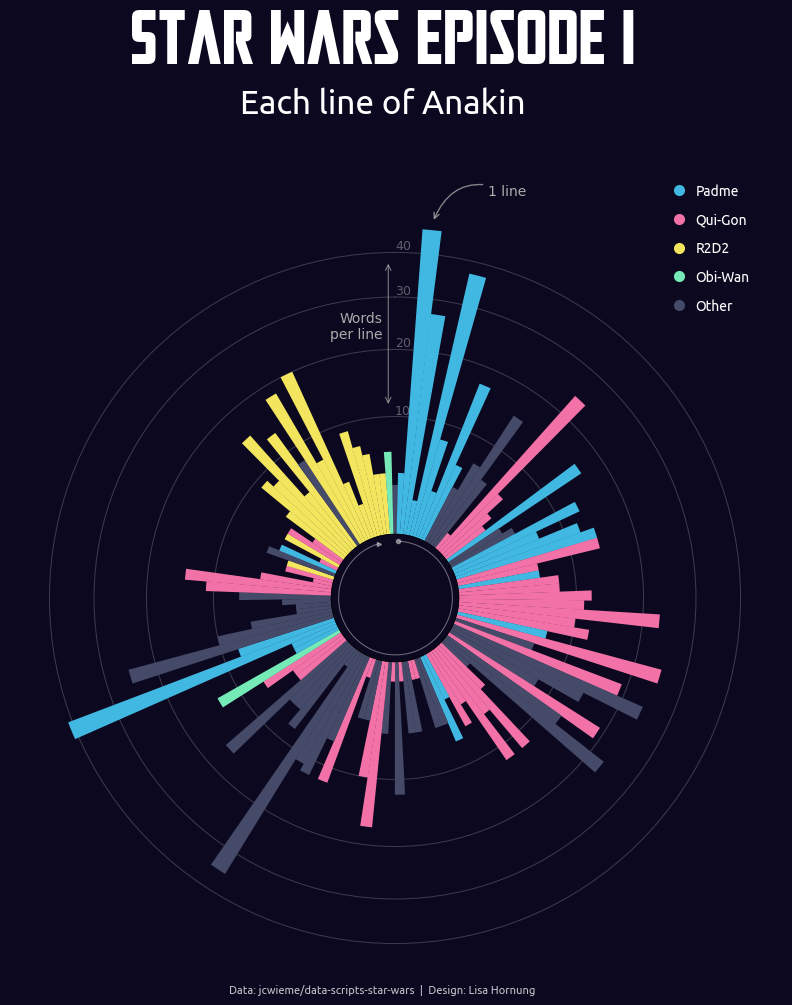

In [509]:
# plot each line of Anakin --> 

# setup
fig, ax = plt.subplots(figsize=(10, 10))
bg_color = '#0C081F'
fig.set_facecolor(bg_color)
ax = plt.subplot(111, polar=True)

# plot data
ax.bar(data["theta_pos"], data["number"], alpha=1, color=data["colors"] , linewidth=0, width=0.052, zorder=3)

# format yaxis
max_value = 50
r_offset = -10
r2 = max_value - r_offset
alpha = r2 - r_offset
v_offset = r_offset**2 / alpha
forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset
reverse = lambda radius: (radius - r_offset) ** 2 / alpha - v_offset

ax.set_rlim(0, max_value)
ax.set_rorigin(r_offset)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)   
ax.set_yscale('function', functions=(
    lambda value: np.where(value >= 0, forward(value), value),
    lambda radius: np.where(radius > 0, reverse(radius), radius)))

# format labels and grid
ax.set_rlabel_position(0)
ax.set_yticks([10,20,30,40])
ax.set_yticklabels([10,20,30,40],fontsize=9, color="white",alpha=0.35)
ax.set_thetagrids(angles=[])
ax.grid(visible=True, axis='y', zorder=2, color = "white", linewidth=0.75, alpha=0.2)
ax.spines[:].set_visible(False)
ax.set_facecolor(bg_color)

# Add inner circle
circ = fig.add_axes([0.453, 0.435, 0.12, 0.12],polar=True) 
line_theta = data["theta_pos"][1:-5]
line_r = [5] * len(line_theta)
circ.plot(line_theta, line_r, zorder=5, color="white", linewidth=0.75, alpha=0.4)
circ.plot(line_theta.to_list()[0], line_r[0], zorder=5, color="white", linewidth=0,marker="o", markersize=3,alpha=0.4)
circ.plot(line_theta.to_list()[-1], line_r[-1], zorder=5, color="white", linewidth=0,marker=">", markersize=3,alpha=0.4)
circ.set_theta_zero_location("N")
circ.set_theta_direction(-1)  
circ.axis("off")


# Add legend
lgd = fig.add_axes([0.75,0.72, 0.15, 0.25]) 
kw = dict(marker='o', color=bg_color, markersize=8, alpha=1, markeredgecolor="None", linewidth=0)
legend_elements2 =[Line2D([0], [0], markerfacecolor=colr_map["PADME"], label="Padme", **kw), 
                  Line2D([0], [0], markerfacecolor=colr_map["QUI-GON"], label="Qui-Gon", **kw), 
                  Line2D([0], [0], markerfacecolor=colr_map["R2D2"], label="R2D2", **kw), 
                  Line2D([0], [0], markerfacecolor=colr_map["OBI-WAN"], label="Obi-Wan", **kw), 
                  Line2D([0], [0], markerfacecolor=colr_other, label="Other", **kw)] 
L = lgd.legend(frameon=False, handles=legend_elements2, loc='center', ncol=1, handletextpad=0.2,labelspacing=1)
plt.setp(L.texts,  va="baseline",color="white", size=14, fontproperties = label_font,)    
lgd.axis("off")

# annotation
ax.annotate('1 line', xy=(0.1, 48), xycoords='data', xytext=(40, 20), textcoords='offset points', 
                   fontsize=10,  ha='left', va='baseline', annotation_clip=False, color="#ababab",
                    arrowprops=dict(arrowstyle="->",edgecolor="#ababab", connectionstyle="arc3,rad=.5", alpha=0.75))
ax.annotate('Words\nper line', xy=(-0.05, 22), xycoords='data', xytext=(0, 0), textcoords='offset points', 
                   fontsize=10,  ha='right', va='baseline', annotation_clip=False, color="#ababab",)
ax.annotate('', xy=(-0.02, 38), xycoords='data', xytext=(0, -105), textcoords='offset points', 
                   fontsize=10,  ha='right', va='baseline', annotation_clip=False, color="#ababab",
                   arrowprops=dict(arrowstyle="<->",edgecolor="#ababab", connectionstyle="arc3,rad=0", alpha=0.75, linewidth=0.75)
                    )

# Title
plt.figtext(0.5,1.03, "Star Wars Episode I", fontproperties = title_font, fontsize=55, color="white", ha="center")
plt.figtext(0.5,0.98, "Each line of Anakin", fontproperties = label_font,fontsize=24, color="white", ha="center")
plt.figtext(0.5,0.1, "Data: jcwieme/data-scripts-star-wars  |  Design: Lisa Hornung", fontproperties = label_font,fontsize=8, color="white", ha="center", alpha=0.75)

plt.savefig("episode-I-each-line-anakin.png", bbox_inches='tight', dpi=300, pad_inches=0.8,)
plt.show()


### Episode 1-3: Total words per line

Polar bar plot --> y-axis scaled using [this method](https://www.chiark.greenend.org.uk/~peterb/python/polar/)

In [153]:
data = df[(df["from"]=="ANAKIN") & (df["episode"].isin(["1", "2", "3"]))]
data = data[["id", "to", "text", "number", "episode"]]
data.head()

,id,to,text,number,episode
271,271.0,WATTO,Mel tassa cho-passa,3,1
274,274.0,PADME,Are you an angel?,4,1
276,276.0,PADME,An angel. I've heard the deep space pilots tal...,46,1
278,278.0,PADME,I listen to all the traders and star pilots wh...,27,1
280,280.0,PADME,All mylife.,2,1


In [154]:
data_filtered = df[(df["from"]=="ANAKIN") & (df["episode"].isin(["1", "2", "3"]))]
data_filtered = data_filtered[["id", "to", "text", "number", "episode"]]

data_to_plot = []

for episode in ["1", "2", "3"]:
    data = data_filtered[data_filtered["episode"]==episode].copy()

    # calculate corect angular position in circle
    x_max = 2*np.pi
    x_coords = np.linspace(0, x_max, len(data), endpoint=False)

    #map x_coords to index
    dictionary = dict(zip(data.index.to_list(), x_coords))

    # loop through index and assign x_pos (for normal scatter plot) + theta_pos (for polar scatter plot)
    x_pos = []
    theta_pos = []
    for i, value in enumerate(data.index.map(dictionary)):
        x_pos.append(i)
        theta_pos.append(value)

    data["x_pos"] = x_pos
    data["theta_pos"] = theta_pos

    data_to_plot.append(data)

data_to_plot = pd.concat(data_to_plot)
data_to_plot.head()

,id,to,text,number,episode,x_pos,theta_pos
271,271.0,WATTO,Mel tassa cho-passa,3,1,0,0.000000
274,274.0,PADME,Are you an angel?,4,1,1,0.050265
276,276.0,PADME,An angel. I've heard the deep space pilots tal...,46,1,2,0.100531
278,278.0,PADME,I listen to all the traders and star pilots wh...,27,1,3,0.150796
280,280.0,PADME,All mylife.,2,1,4,0.201062


C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_26224\3462943301.py:21: RuntimeWarning: invalid value encountered in sqrt
  forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset


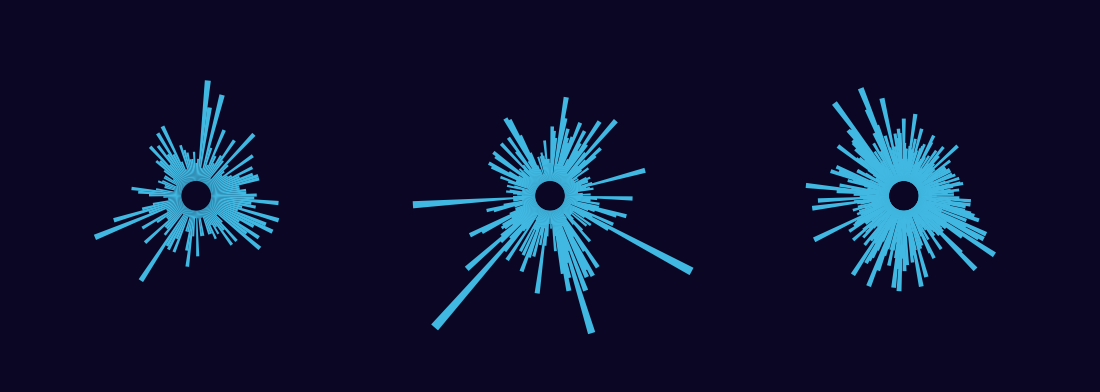

In [138]:
# plot each line of Anakin --> 

# setup
#layout = [["1"], ["2"], ["3"]]
layout = [["1", "2", "3"]]
fig,axs = plt.subplot_mosaic(layout, figsize=(12,8), subplot_kw={'projection': 'polar'}) 
plt.subplots_adjust(wspace=-0.05, hspace=0.1, left=0.05, right=0.95, bottom=0.05)
fig.set_facecolor('#0B0624')

# plot data
for ax in axs:
    data = data_to_plot[data_to_plot["episode"]==ax]
    axs[ax].bar(data["theta_pos"], data["number"], alpha=1, color="#40B8E1" , linewidth=0, width=0.052)

# format axis
max_value = 110
r_offset = -10
r2 = max_value - r_offset
alpha = r2 - r_offset
v_offset = r_offset**2 / alpha
forward = lambda value: ((value + v_offset) * alpha)**0.5 + r_offset
reverse = lambda radius: (radius - r_offset) ** 2 / alpha - v_offset

for ax in axs:
    axs[ax].set_rlim(0, 120)
    axs[ax].set_rorigin(r_offset)
    axs[ax].set_theta_zero_location("N")
    axs[ax].set_theta_direction(-1)
    
    axs[ax].set_yscale('function', functions=(
        lambda value: np.where(value >= 0, forward(value), value),
        lambda radius: np.where(radius > 0, reverse(radius), radius)))
    axs[ax].axis("off")

### Episode 1: Each word + letter

In [13]:
data = df[df["from_clean"]=="ANAKIN"]

text_dict = {"id": [], "to":[], "word": [], "letters": []}

for index in data.index:
    text_dict["id"].append(index)
    text_dict["to"].append(data.loc[index]["to_clean"])
    text_dict["word"].append(np.arange(0,len(data.loc[index]["text"].split(" "))))
    
    letters = []
    for word in data.loc[index]["text"].split(" "):
        letters.append(len(word)*15)
    text_dict["letters"].append(letters)

text_df = pd.DataFrame(text_dict)
text_df.head()


,id,to,word,letters
0,271,WATTO,"[0, 1, 2]","[45, 75, 135]"
1,274,PADME,"[0, 1, 2, 3]","[45, 45, 30, 90]"
2,276,PADME,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 90, 60, 75, 45, 60, 75, 90, 60, 75, 75, 6..."
3,278,PADME,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[15, 90, 30, 45, 45, 105, 45, 60, 90, 45, 60, ..."
4,280,PADME,"[0, 1]","[45, 105]"


In [14]:
# calculate corect angular position in circle
x_max = 2*np.pi
x_coords = np.linspace(0, x_max, len(data), endpoint=False)

#map x_coords to index
dictionary = dict(zip(text_df.index.to_list(), x_coords))

# loop through index and assign x_pos (for normal scatter plot) + theta_pos (for polar scatter plot)
x_pos = []
theta_pos = []
for i, value in enumerate(text_df.index.map(dictionary)):
    x = []
    theta = []
    for words in range(len(text_df.loc[i]["word"])):
        #new_i = str(i)
        x.append(i)
        theta.append(value)
    x_pos.append(x)
    theta_pos.append(theta)

text_df["x_pos"] = x_pos
text_df["theta_pos"] = theta_pos

text_df

,id,to,word,letters,x_pos,theta_pos
0,271,WATTO,"[0, 1, 2]","[45, 75, 135]","[0, 0, 0]","[0.0, 0.0, 0.0]"
1,274,PADME,"[0, 1, 2, 3]","[45, 45, 30, 90]","[1, 1, 1, 1]","[0.05026548245743669, 0.05026548245743669, 0.0..."
2,276,PADME,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[30, 90, 60, 75, 45, 60, 75, 90, 60, 75, 75, 6...","[2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, ...","[0.10053096491487339, 0.10053096491487339, 0.1..."
3,278,PADME,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[15, 90, 30, 45, 45, 105, 45, 60, 90, 45, 60, ...","[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[0.15079644737231007, 0.15079644737231007, 0.1..."
4,280,PADME,"[0, 1]","[45, 105]","[4, 4]","[0.20106192982974677, 0.20106192982974677]"
...,...,...,...,...,...,...
120,909,R2D2,"[0, 1, 2, 3, 4, 5, 6]","[180, 165, 45, 45, 90, 45, 60]","[120, 120, 120, 120, 120, 120, 120]","[6.031857894892403, 6.031857894892403, 6.03185..."
121,923,R2D2,"[0, 1, 2, 3, 4, 5]","[60, 30, 60, 90, 105, 45]","[121, 121, 121, 121, 121, 121]","[6.0821233773498395, 6.0821233773498395, 6.082..."
122,925,R2D2,"[0, 1, 2, 3]","[75, 45, 75, 75]","[122, 122, 122, 122]","[6.132388859807277, 6.132388859807277, 6.13238..."
123,927,R2D2,"[0, 1, 2, 3]","[60, 60, 30, 150]","[123, 123, 123, 123]","[6.182654342264713, 6.182654342264713, 6.18265..."


In [15]:
# define colors
colr_map = {"QUI-GON": "#F271A7", "PADME": "#40B8E1", "OBI-WAN":"#75EAB6" , "R2D2": "#EBDF71"}

text_df["colors"] = text_df["to"].map(colr_map)
text_df["colors"] = text_df["colors"].fillna("#5F6689")

C:\Users\lisa.hornung\AppData\Local\Temp\ipykernel_26224\2343823563.py:6: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  ax = plt.subplot(111, polar=True)


(0.0, 6.283185307179586, -5.0, 50.0)

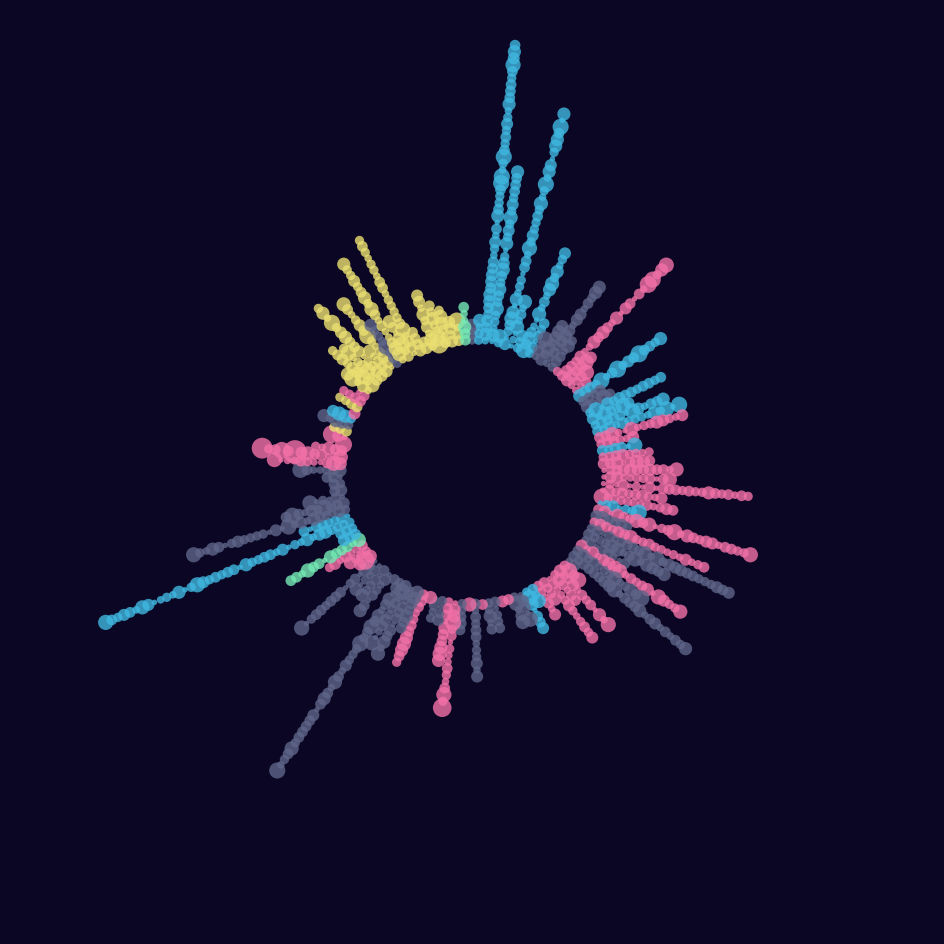

In [16]:
# plot each line of Anakin --> 

# setup
fig, ax = plt.subplots(figsize=(12, 12))
fig.set_facecolor('#0B0624')
ax = plt.subplot(111, polar=True)

# plot data
for i in range(0,len(text_df)):
    ax.scatter(text_df.loc[i]["theta_pos"], text_df.loc[i]["word"], s= text_df.loc[i]["letters"], alpha=0.8, color=text_df.loc[i]["colors"] , linewidth=0)

# format axis
ax.set_ylim(ymin=-5, ymax=50)
ax.set_rorigin(-20)
ax.set_theta_zero_location("N")
ax.set_theta_direction(-1)
ax.axis("off")

## Who speaks to whom

Chord diagram made in 

- R
- D3

In [12]:
matrix = chord
matrix = matrix.pivot(index="from_clean", columns="to_clean", values="count")
matrix = matrix.fillna(0)

matrix.to_numpy()
#df.pivot(index='foo', columns='bar', values=['baz', 'zoo'])

array([[ 0.,  2.,  3.,  2.,  0.,  5.,  0.,  4.,  0.,  5.,  0.,  0.,  2.,
         1., 11.,  4.,  1.,  0.,  0.,  0.,  0.,  3.,  0.,  0.],
       [ 2.,  0.,  0.,  0.,  3.,  0.,  0.,  1.,  1.,  0.,  2.,  0.,  3.,
        23.,  0., 42., 18.,  1.,  0.,  4., 19.,  0.,  2.,  3.],
       [ 5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,
         1.,  0.,  2.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 1.,  0.,  0.,  0.,  0.,  0.,  0.,  4.,  0.,  0.,  2.,  0.,  0.,
         2.,  0.,  7.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  5.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
         0.,  0.,  0., 10.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [11.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,  4.,  0.,  6.,
         4.,  0.,  9.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 14.,  0.,  0.,  3.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 4., 13.,  0.,  3.,  0.,  0.,  0.

In [14]:
matrix.index.str.title()

Index(['Amidala', 'Anakin', 'Bibble', 'Boss Nass', 'C-3Po', 'Capt. Panaka',
       'Darth Sidious', 'Jar Jar', 'Mace Windu', 'Nute', 'Obi-Wan', 'Oom-9',
       'Other', 'Padme', 'Palpatine', 'Qui-Gon', 'R2D2', 'Ric Olie', 'Rune',
       'Sebulba', 'Shmi', 'Valorum', 'Watto', 'Yoda'],
      dtype='object', name='from_clean')